In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

In [5]:
# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=6, resize=1.0)
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

# Resize images to 299x299 for InceptionV3
def preprocess_images(X):
    X_resized = []
    for img in X:
        img_rgb = np.stack([img] * 3, axis=-1)
        img_resized = array_to_img(img_rgb).resize((299, 299))
        img_resized = img_to_array(img_resized)
        X_resized.append(img_resized)
    return preprocess_input(np.array(X_resized))

X_resized = preprocess_images(X)
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.25, random_state=42)


In [6]:
# Define Q-learning parameters
augmentations = [
    {"rotation_range": 10},
    {"width_shift_range": 0.1},
    {"height_shift_range": 0.1},
    {"horizontal_flip": True},
    {"zoom_range": 0.1}
]
q_table = np.zeros(len(augmentations))
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.1

In [9]:
# Define Gamma adjustment function
def adjust_gamma(image, gamma):
    # ensure the value is in 0 to 255, convert it to uint8
    image = np.clip(image, 0, 1)  # 如果图像为 [0, 1] 范围
    image = (image * 255).astype("uint8")
    
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    
    return cv2.LUT(image, table)


In [10]:
# Generate gamma-adjusted test sets
gamma_values = [0.5, 0.8, 1.0, 1.2, 1.5]
X_test_gamma = {gamma: np.array([adjust_gamma(img, gamma) for img in X_test]) for gamma in gamma_values}


In [11]:
# Load InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(target_names), activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)


87910968/87910968 [==============================] - 2s 0us/step


In [12]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [13]:
# Function to select augmentation based on Q-learning
def select_augmentation():
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(augmentations))
    else:
        return np.argmax(q_table)

In [14]:
# Update Q-table
def update_q_table(augmentation_idx, reward):
    best_next_action = np.max(q_table)
    q_table[augmentation_idx] += learning_rate * (reward + discount_factor * best_next_action - q_table[augmentation_idx])


In [15]:
# Adaptive data generator with Q-learning
def augmented_generator(X, y, batch_size=32):
    while True:
        augmentation_idx = select_augmentation()
        chosen_augmentation = augmentations[augmentation_idx]
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input, **chosen_augmentation)
        gen = datagen.flow(X, y, batch_size=batch_size)
        
        X_batch, y_batch = next(gen)
        yield X_batch, y_batch
        
        reward = evaluate_reward(model, X_batch, y_batch)
        update_q_table(augmentation_idx, reward)

In [16]:
# Evaluate reward based on accuracy
def evaluate_reward(model, X_batch, y_batch):
    _, accuracy = model.evaluate(X_batch, y_batch, verbose=0)
    return accuracy

In [17]:
# Training loop
epochs = 5
batch_size = 32
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.fit(
        augmented_generator(X_train, y_train, batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        validation_data=(X_test, y_test),
        epochs=1
    )

Epoch 1/5
127/127 [==============================] - 190s 1s/step - loss: 4.8185 - accuracy: 0.1875 - val_loss: 6.2184 - val_accuracy: 0.0951
Epoch 2/5
127/127 [==============================] - 193s 2s/step - loss: 5.1957 - accuracy: 0.0625 - val_loss: 6.0026 - val_accuracy: 0.0951
Epoch 3/5
127/127 [==============================] - 196s 2s/step - loss: 5.2110 - accuracy: 0.0312 - val_loss: 6.1312 - val_accuracy: 0.0951
Epoch 4/5
127/127 [==============================] - 200s 2s/step - loss: 5.0867 - accuracy: 0.0625 - val_loss: 6.4430 - val_accuracy: 0.0936
Epoch 5/5
127/127 [==============================] - 189s 1s/step - loss: 4.9197 - accuracy: 0.1250 - val_loss: 6.8977 - val_accuracy: 0.0206


In [19]:
# Evaluate robustness with gamma-adjusted data
gamma_accuracies = {}
for gamma, X_test_adj in X_test_gamma.items():
    _, accuracy = model.evaluate(X_test_adj, y_test, verbose=0)
    gamma_accuracies[gamma] = accuracy
    print(f"Gamma {gamma}: Accuracy = {accuracy:.4f}")

Gamma 0.5: Accuracy = 0.0118
Gamma 0.8: Accuracy = 0.0088
Gamma 1.0: Accuracy = 0.0096
Gamma 1.2: Accuracy = 0.0096
Gamma 1.5: Accuracy = 0.0088


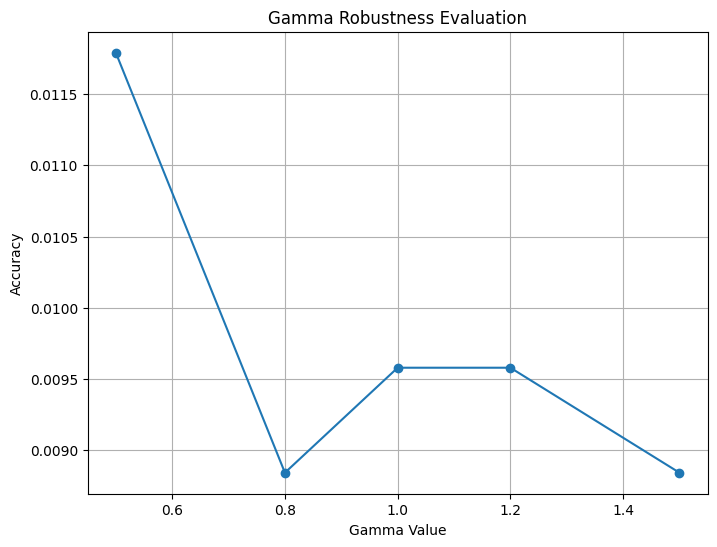

In [20]:
# Plot gamma robustness
plt.figure(figsize=(8, 6))
plt.plot(gamma_accuracies.keys(), gamma_accuracies.values(), marker="o")
plt.title("Gamma Robustness Evaluation")
plt.xlabel("Gamma Value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()